# Module 02: Training Splits

### Load necessary packages

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from ISLP.models import summarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

### Create helper functions for computing predictions and the mean squared error

In [6]:

def predict(X, model):
    '''
    The built-in "get_prediction" tool in ISLP returns an array, so this is just a wrapper which converts the result to a dataframe.
    '''
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    '''
    Returns the mean squared error, which we will use to evaluate how well a linear regression model fits a dataset.

    The details of this function will be explored further in module 04.
    '''
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

### Randomly generate a dataset using the equation y = x - 2x^2

In [7]:

# Always specify a seed so that the data can be regenerated
# DON'T change anything in this cell.
seed = 314

# Create a random number generator called rng
rng = np.random.default_rng(seed)

# Use the random number generator to create x- and y-coordinates
x = rng.normal(size=150)
y = x - 2 * x**2 + rng.normal(size=150)

### Create a dataframe we can use to build three different models

In [8]:
# We'll need a collection of independent variables. We'll use x, x^2, x^3, and a constant (which will be used to calculate the intercept)
new_x = pd.DataFrame(np.column_stack((x**0, x, x**2, x**3)), columns=['intercept','x','x_sq','x_cu'])

# print the dataframe
new_x

,intercept,x,x_sq,x_cu
0,1.0,-0.623223,0.388407,-0.242064
1,1.0,-0.556297,0.309466,-0.172155
2,1.0,0.037388,0.001398,0.000052
3,1.0,0.995960,0.991937,0.987930
4,1.0,0.029919,0.000895,0.000027
...,...,...,...,...
145,1.0,0.193035,0.037263,0.007193
146,1.0,-0.536687,0.288033,-0.154584
147,1.0,0.879224,0.773036,0.679672
148,1.0,-0.443387,0.196592,-0.087166


### Split the data into train and test

In [9]:
# Note that we need to choose a random seed and the percent of records withheld for testing
x_train, x_test, y_train, y_test = train_test_split(new_x,
                                                    y,
                                                    random_state=314159,
                                                    test_size=0.33,
                                                    shuffle=True) 

### Graph the training data

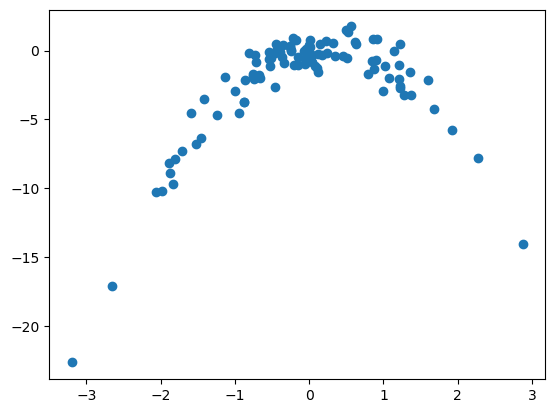

In [10]:
# It's important to do this after the train/test split is created. We shouldn't look at data that's withheld for testing.
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)

### First we'll a quadratic model, which should be appropriate since the data was randomly generated based on a quadratic equation

In [11]:
# Fit a quadratic model
model_quad = sm.OLS(y_train, x_train[['intercept','x','x_sq']])
results_quad = model_quad.fit()
summarize(results_quad)

,coef,std err,t,P>|t|
intercept,0.0943,0.114,0.830,0.408
x,0.9255,0.092,10.028,0.000
x_sq,-1.9932,0.056,-35.579,0.000


In [12]:
# Get predictions
x_train['pred_sq'] = predict(x_train[['intercept', 'x', 'x_sq']], results_quad)

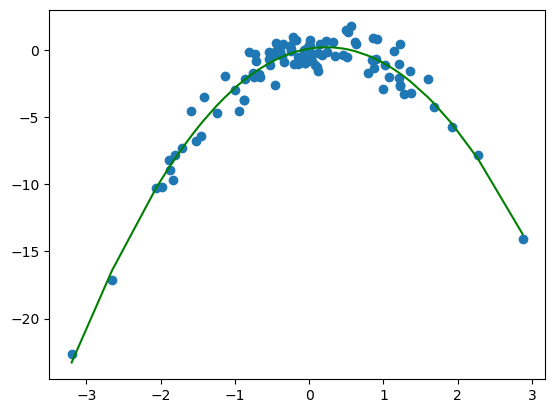

In [13]:
# Plot predictions as solid green line, along with the original training data
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
quadratic = x_train[['x','pred_sq']].sort_values('x')
ax.plot(quadratic['x'],quadratic['pred_sq'], color='green')

### Next we'll create an underfit model and observe the performance on training.

In [29]:
# Fit a linear model
model_lin = sm.OLS(y_train, x_train[['intercept','x']])
results_lin = model_lin.fit()
summarize(results_lin)

,coef,std err,t,P>|t|
intercept,-2.0760,0.358,-5.807,0.0
x,1.5604,0.338,4.621,0.0


In [32]:
# Get model predictions
predictions_lin_train = results_lin.predict(x_train[['intercept','x']])

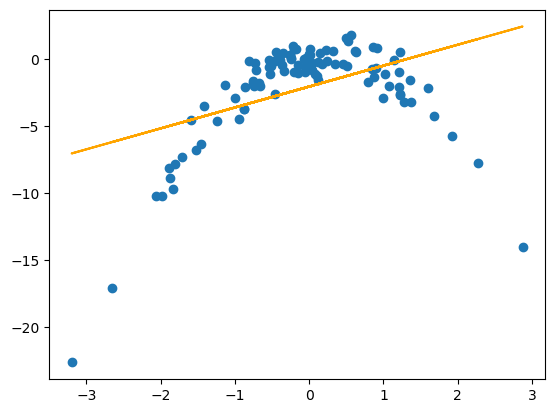

In [34]:
# Plot predictions as solid *orange* line
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
linear = results_lin.predict(x_train[['intercept','x']])
ax.plot(x_train['x'], linear, color='orange')

### And lastly we'll build an overfit model and observe the performance on training.

In [20]:
# Fit a cubic model
model_cubic = sm.OLS(y_train,
                     np.column_stack([np.ones(len(x_train)),
                                      x_train['x'],
                                      x_train['x']**2,
                                      x_train['x']**3]))
results_cubic = model_cubic.fit()
summarize(results_cubic)

,coef,std err,t,P>|t|
const,0.0992,0.115,0.861,0.391
x1,0.9617,0.147,6.528,0.000
x2,-1.9984,0.059,-34.068,0.000
x3,-0.0099,0.031,-0.316,0.753


In [40]:
# Get predictions
x_train['pred_cu'] = results_cubic.predict(
    np.column_stack([
        np.ones(len(x_train)),
        x_train['x'],
        x_train['x']**2,
        x_train['x']**3
    ])
)

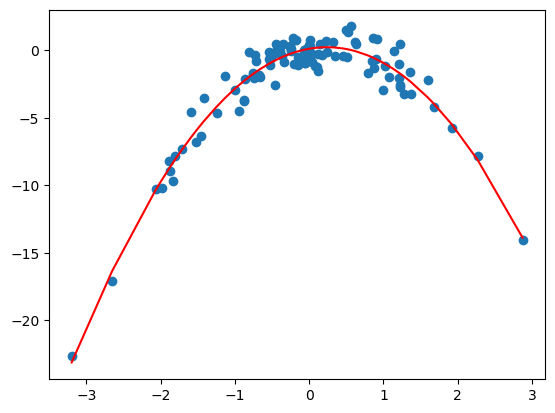

In [42]:
# Plot predictions as solid *red* line
order = np.argsort(x_train['x'])
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
cubic = results_cubic.predict(
    np.column_stack([
        np.ones(len(x_train)),
        x_train['x'],
        x_train['x']**2,
        x_train['x']**3
    ])
)
ax.plot(
    x_train['x'].iloc[order],
    cubic[order],
    color='red')

### After observing the resulting three plots on the training set, how do the models compare? Is one clearly the best? Is one clearly the worst?

The first plot gave a quadratic line that matched the data well and had a good balance between bias and variance. The second plot, which was underfit, assumed a linear shape to the data, didn't match the data well and had too much bias. The third plot, which was cubic was very similar to the quadratic model, but may be slightly overfit and will therefore not do as well on the test data. The quadratic and cubic are very similar, and match the data well, and the linear does not match the data at all.

### Now we'll calculate the errors (MSE) for each model on the training and test sets.

In [35]:
# Calculate the MSE on the training set for each model
predictions_lin_train = predict(x_train[['intercept', 'x']], results_lin)
predictions_quad_train = predict(x_train[['intercept', 'x', 'x_sq']], results_quad)
predictions_cubic_train = predict(x_train[['intercept', 'x', 'x_sq', 'x_cu']], results_cubic)

print('mse train linear   :',mse(y_train, predictions_lin_train))
print('mse train quadratic:',mse(y_train, predictions_quad_train))
print('mse train cubic    :',mse(y_train, predictions_cubic_train))

mse train linear   : 12.412966288823755
mse train quadratic: 0.8834818567246725
mse train cubic    : 0.882565936613727


In [37]:
# Calculate the MSE on the test set for each model
predictions_lin_test = results_lin.predict(x_test[['intercept','x']])
predictions_quad_test = results_quad.predict(x_test[['intercept','x','x_sq']])
predictions_cubic_test = results_cubic.predict(
    np.column_stack([
        np.ones(len(x_test)),
        x_test['x'],
        x_test['x']**2,
        x_test['x']**3
    ])
)

print('mse test linear   :',mse(y_test, predictions_lin_test))
print('mse test quadratic:',mse(y_test, predictions_quad_test))
print('mse test cubic    :',mse(y_test, predictions_cubic_test))

mse test linear   : 4.384456331794724
mse test quadratic: 1.17228301269326
mse test cubic    : 1.1747427656171414


### Describe the results for each of the three models in terms of their performance on training data and on test data. Which model is most likely underfit? Which is most likely overfit?

The linear model had high error for both the training and test data, and we can determine conclusively that it was very underfit to the data. The quadratic model had higher error on the test set than it did on the training set but seems to be a good fit (good balance between bias and variance for this model). The cubic model looked very similar to the quadratic one on both the graphs and the error for the training and test data, although it did have lower training error than quadratic, and higher test error (each a difference of .02). This indicates that for the number of objects in this set, the cubic might be usable, but for a much larger data set, the cubic model would likely be overfit to the training data.